# Practical Week 3: Heuristic Searching

In this practical you will implement several informed search algorithms and apply them on examples. This work is to build your understanding of and ability to implementing search algorithms. This work is not assessed, and you do not need to submit it. Please ask questions if you are facing difficulties with any of the content in this practical.

This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module.

Let's start by mounting Google Drive and set the import path (if you are working in Google Colab). You may need to adjust the path depending on where in you Google Drive you have placed the Python files.

In [1]:
# mount Google Drive. You could also mount Google Drive using the Files tab on the left.
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    pass # we're not using Google Colab

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

Now let's import everything from the search module and other required modules. This notebook requires the same python modules as the Week 2 practical notebook: `search.py`, `utils.py`, and `notebook_comp2019.py`.

In [4]:
import search
from search import *
from notebook_comp2019 import psource, show_map, GraphSearchRecorder
from math import sqrt

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

Next, we setup the Romania Map problem from the Week 2 Practical.

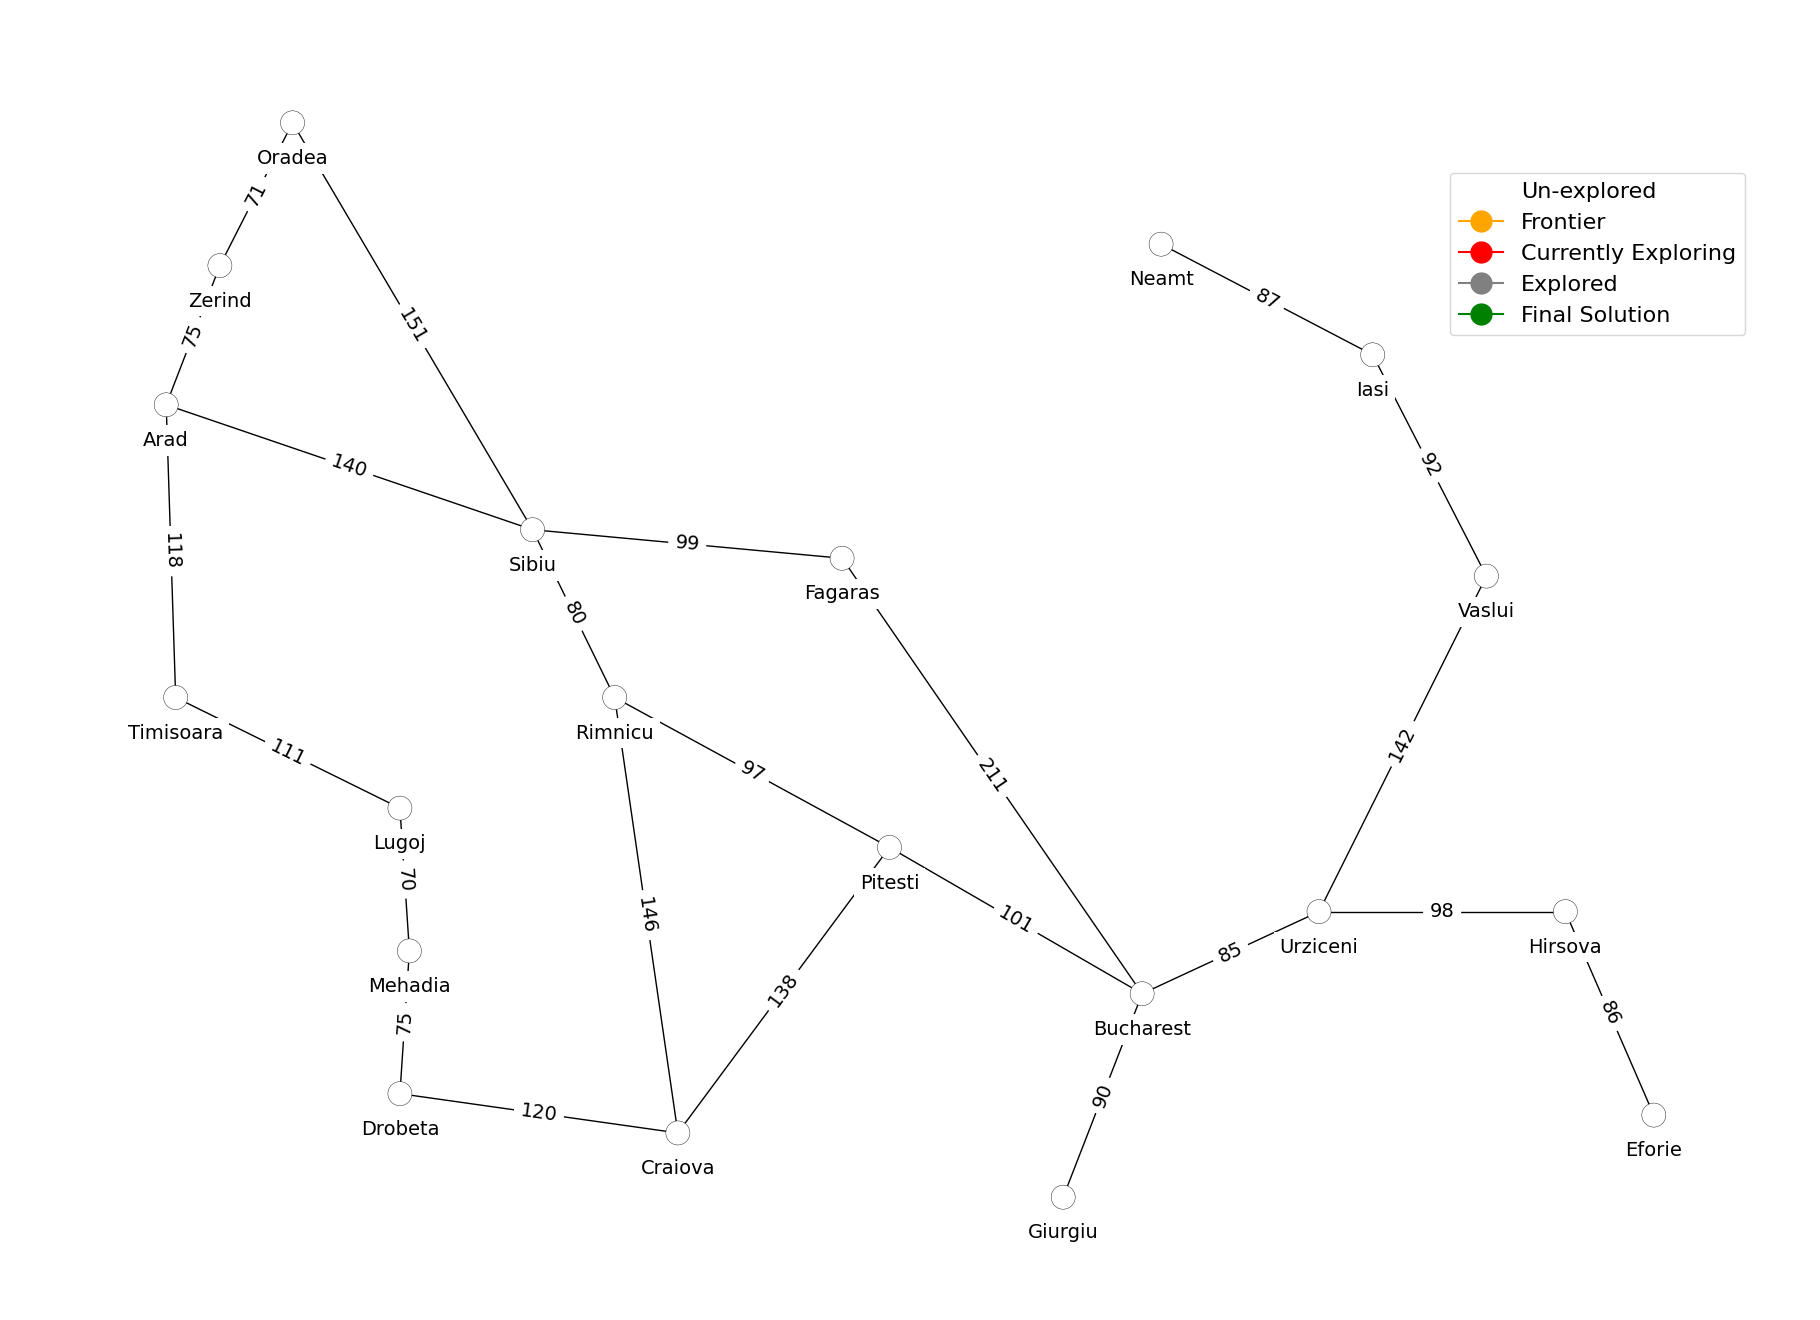

In [7]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                     }

romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
show_map(romania_graph_data)

## ACTIVITY 1: Heuristics

In this practical, we will examine heuristic search methods. Heuristic search methods make use of information about the specific problem under consideration so that the search can be performed more efficiently. For the Romania route finding problem, we will exploit information about how close to the goal node, Bucharest, each path gets.

To assess "closeness", we shall define a suitable heuristic function based on the map layout. Since this is a flat map (let's ignore effects due to Earth curvature and projection of spherical coordinates onto a flat surface), we can consider the Euclidean distance to measure how close each graph node is to Bucharest. The Euclidean Distance is also known as "straight-line distance", as it measures the length of a straight line whose endpoints are located at two nodes.

Class `GraphProblem` in `search.py` already implements this distance function for us. Let's look at method `h` that implements the distance:

In [5]:
psource(GraphProblem)

Method `h` obtains the coordinates associated with the node supplied as the argument `node` and the goal node `self.goal`. It then invokes the `distance` function, which computes the Euclidean distance between the two points according using the formula

$$\sqrt{(node.x - goal.x)^2 + (node.y - goal.y)^2}$$

Let's see what distance `h` returns for a some nodes:

In [8]:
for node in ['Arad', 'Fagaras', 'Oradea','Craiova','Bucharest']:
    print(f"Estimated distance from {node} to {romania_problem.goal} is {romania_problem.h(node)}")

Estimated distance from Arad to Bucharest is 350
Estimated distance from Fagaras to Bucharest is 154
Estimated distance from Oradea to Bucharest is 363
Estimated distance from Craiova to Bucharest is 152
Estimated distance from Bucharest to Bucharest is 0


We see that  

* all estimated distances are positive and non-zero,
* the estimated distance to the goal is zero, and
* all estimated distances are less than the actual distance to the goal. That is, the distance measure does not over-estimate the actual distances.

We could also verify that this distance metric satisfies the triangle inequality required for **consistency**. We won't do that here, but it is not difficult to show using some algebra and the fact that the straight-line distance is the shortest distance between any two points on a flat Euclidean map. Alternatively, we could simply check that for all edges `x --c--> y` in the graph, $h(x) - h(y) \le c$.

Since we will be using the A* algorithm here, this tells us that this distance metric is a consistent heuristic function that will guarantee that the first solution our heuristic search finds is indeed the optimal solution.

Next, we will write some code that computes the total estimated distance for a path originating in the initial state of the search problem, traversing through a given state, `n`, and ending in the goal state, `Bucharest`. This total estimated distance can be decomposed in two parts, as discussed in the lecture:

* the distance from the initial state `Arad` to the current state `n` corresponds to the actual path cost of the path from `Arad` to `n` in the graph, and
* the estimated distance for the "gap" between `n` and `Bucharest` can be found using the heuristic function `h` we just discussed.

Let's look at an example path: Arad-Zerind-Oradea-Sibiu.
Calculate the actual path cost, `g` for this path. You can simply read off the relevant costs from the map and sum them in the cell below.

In [12]:
g_AZOS = 71 + 75 + 151
print(g_AZOS)

297


Then, compute the total estimated path cost, `f_AZOS`, from `Arad` to `Bucharest` via `Zerind`,  `Oradea`, and `Sibiu`. Use the `romania_problem` compute this distance.

In [13]:
f_AZOS = g_AZOR + romania_problem.h('Sibiu')
print(f_AZOS)

529


We learn that we must travel at least 529 units to reach Bucharest via this path.


Let's try another path: Arad-Sibiu.
Compute the actual partial path costs for the Path `Arad`-`Sibiu` and the totat estimated path costs from `Arad` to `Bucharest` via the partial path to `Sibiu`.

In [16]:
g_AS = 140
f_AS = 140 + romania_problem.h('Sibiu')
print(g_AS)
print(f_AS)

140
372


## ACTIVITY 2: Generalise Best-First Search

Next, we will revisit the **Best First Search** algorithm we implemented last week and generalise it for use with custom distance functions.

Here is last week's code for Best-First Search:

In [17]:
def best_first_graph_search_ucs(problem):
    """Search through the successors of a problem to find a goal.
    Consider the cost of actions.
    Detect repeated paths to a state.
    Record the events that are occurring during the search."""

    # we use the recorder object to record events during the search
    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)
    frontier = PriorityQueue('min', lambda n: n.path_cost)
    frontier.append(initial_node)
    recorder.added_to_frontier(initial_node)

    explored = set()

    while frontier:

        # TODO

        node = frontier.pop()
        recorder.visited(node)

        if problem.goal_test(node.state):
            recorder.goal_found(node)
            return (recorder, node)

        explored.add(node)
        recorder.explored(node)

        # add child nodes to the frontier (or return if a child is a goal)
        child_nodes = node.expand(problem)
        for child_node in child_nodes:
            if child_node in explored:
                continue
            if child_node not in frontier:
                frontier.append(child_node)
                recorder.added_to_frontier(child_node)
            else:
                incumbent_cost = frontier[child_node]
                if child_node.path_cost < incumbent_cost:
                    del frontier[child_node]   # deletes the incumbent (because child_node and the incumbent refer to the same state and hence compare equal)
                    frontier.append(child_node)

    # no solution found
    return (recorder, None)

Let's recall how this search traverses the Romania map:

In [18]:
recorder, goal_node = best_first_graph_search_ucs(romania_problem)
recorder.print_visited_paths()
print(f"The cost of the solution path is {goal_node.path_cost}.")
recorder.visualise_search_progress(romania_graph_data)

Explored path at iterations:
1: 
6: Zerind
9: Timisoara
12: Sibiu
16: Zerind-Oradea
18: Sibiu-Rimnicu
22: Timisoara-Lugoj
25: Sibiu-Fagaras
28: Timisoara-Lugoj-Mehadia
31: Sibiu-Rimnicu-Pitesti
33: Sibiu-Rimnicu-Craiova
35: Timisoara-Lugoj-Mehadia-Drobeta
37: Sibiu-Rimnicu-Pitesti-Bucharest
The cost of the solution path is 418.


interactive(children=(IntSlider(value=0, description='iteration', max=38), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

Now revise the algorithm so that it takes an additional argument named `f`, which is a function that computes the total estimated distance from the initial state via a given state (passed as argument to `f`) to the closest goal state.

In [21]:
def best_first_graph_search(problem, f = lambda n: n.path_cost):
    """Search through the successors of a problem to find a goal.
    Consider the cost of actions, where cost is measured by function `f`.
    Detect repeated paths to a state.
    Record the events that are occurring during the search."""

    recorder = GraphSearchRecorder(problem)

    initial_node = Node(problem.initial)
    frontier = PriorityQueue('min', lambda n: f(n))
    frontier.append(initial_node)
    recorder.added_to_frontier(initial_node)

    explored = set()

    while frontier:

        # TODO

        node = frontier.pop()
        recorder.visited(node)

        if problem.goal_test(node.state):
            recorder.goal_found(node)
            return (recorder, node)

        explored.add(node)
        recorder.explored(node)

        # add child nodes to the frontier (or return if a child is a goal)
        child_nodes = node.expand(problem)
        for child_node in child_nodes:
            if child_node in explored:
                continue
            if child_node not in frontier:
                frontier.append(child_node)
                recorder.added_to_frontier(child_node)
            else:
                incumbent_cost = frontier[child_node]
                if child_node.path_cost < incumbent_cost:
                    del frontier[child_node]   # deletes the incumbent (because child_node and the incumbent refer to the same state and hence compare equal)
                    frontier.append(child_node)

    # no solution found
    return (recorder, None)

Define a function that given a node, return the actual path cost from the initial state to that node.

In [24]:
def f_ucs(node):
  return node.path_cost

Use that function as the argument for `f` when invoking `best_first_graph_search`.

Since we use a function that simply returns the actual path cost for each node as a default for `f`, this function behaves exactly in the same way as Best-First Search:

In [25]:
recorder, goal_node = best_first_graph_search(romania_problem, f_ucs)
recorder.print_visited_paths()
print(f"The cost of the solution path is {goal_node.path_cost}.")
recorder.visualise_search_progress(romania_graph_data)

Explored path at iterations:
1: 
6: Zerind
9: Timisoara
12: Sibiu
16: Zerind-Oradea
18: Sibiu-Rimnicu
22: Timisoara-Lugoj
25: Sibiu-Fagaras
28: Timisoara-Lugoj-Mehadia
31: Sibiu-Rimnicu-Pitesti
33: Sibiu-Rimnicu-Craiova
35: Timisoara-Lugoj-Mehadia-Drobeta
37: Sibiu-Rimnicu-Pitesti-Bucharest
The cost of the solution path is 418.


interactive(children=(IntSlider(value=0, description='iteration', max=38), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

Now, can you emulate **Breadth-First Search** using that function? Recall that Breadth-First Search finds a path that includes the least number of actions, irrespective of what the action costs may be. Define a function that can be passed as `f` in the above algorithm so that it will find the same solution as Breadth-First Search. Then, run the Best-First Graph Search using that function and verify that it indeed behaves just like Breadth-First Search (without the shortcut we used last week).

In [26]:
recorder, goal_node = best_first_graph_search(romania_problem, lambda n: n.depth)
recorder.print_visited_paths()



Explored path at iterations:
1: 
6: Sibiu
11: Timisoara
14: Zerind
16: Sibiu-Fagaras
19: Timisoara-Lugoj
22: Sibiu-Oradea
24: Sibiu-Rimnicu
28: Sibiu-Fagaras-Bucharest


We can see that indeed this cost function yields the same result as Breadth-First Search in the previous week.

## ACTIVITY 3: Implement A*

Next, we will implement the A* algorithm. Use the generalised Best-First Search algorithm you have developed in the previous section to implement A*.

Hint: This should be quite simple, since A* is just a best-first search using the total estimated distance we calculated earlier. Can you do it in 3 lines of code or less?

In [29]:
def astar_graph_search(problem):
    return best_first_graph_search(romania_problem, f = lambda n: n.path_cost + problem.h(n))

Let's run the algorithm and see how it traverses the map:

In [30]:
recorder, goal_node = astar_graph_search(romania_problem)
recorder.print_visited_paths()
print(f"The cost of the solution path is {goal_node.path_cost}.")
recorder.visualise_search_progress(romania_graph_data)

Explored path at iterations:
1: 
6: Sibiu
11: Sibiu-Fagaras
14: Sibiu-Rimnicu
18: Sibiu-Rimnicu-Pitesti
20: Sibiu-Rimnicu-Pitesti-Bucharest
The cost of the solution path is 418.


interactive(children=(IntSlider(value=0, description='iteration', max=21), Output()), _dom_classes=('widget-in…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

The algorithm indeed finds the same path as Best-First Search. However, it does so more efficiently: we observe that nodes that were expanded by Best-First Search are not expanded by A*. For example, although Zerind is added to the frontier, this node is never expanded, and nodes `Lugoj`, `Mehadia`, and `Drobeta` are not even encountered during the search. As a result, A* finds a solution much quicker than the uninformed search algorithm. Indeed, it performs only 20 steps compared to the 38 steps performed by Best-First Search. Although the efficiency gain is modest for this toy problem, some larger search problems cannot be solved unless efficient heuristic search methods are employed.

## ACTIVITY 4: 8-Puzzle A* Search

In the following, we will solve the 8-Puzzle using A* search.

### 8 Puzzle Problem

The *8 Puzzle Problem* consists of a 3x3 tray in which the goal is to get the initial configuration to the goal state by shifting the numbered tiles into the blank space.

Thus, a **state** in this problem consists of an arrangement of all 8 tiles (and the blank tile, represented as 0) on the tray.

For example, we may wish to find the sequence of moves that transform the initial state into the goal state shown below:

              Initial State                        Goal State
              | 7 | 2 | 4 |                       | 1 | 2 | 3 |
              | 5 | 0 | 6 |                       | 4 | 5 | 6 |
              | 8 | 3 | 1 |                       | 7 | 8 | 0 |
              
The state space for this search problem consists of all (solvable) possible arrangements of tiles on the tray. We have a total of 9 tiles giving us a total of 9! (=362,880) initial configurations.

 However, not all of these are solvable. The solvability of a configuration can be checked by calculating the Inversion Permutation, but we won't discuss that here in detail. If the total Inversion Permutation is even then the initial configuration is solvable else the initial configuration is not solvable which means that only 9!/2 initial states lead to a solution.

Let's define our goal state.

In [31]:
goal = (1, 2, 3, 4, 5, 6, 7, 8, 0)

We will assume that the goal state remains fixed for the rest of this practical.

Next, let's examine the actions that we have available to traverse the state space. When using the physical game tray, we would shift one of the numbered tiles that is adjacent to the blank space into the blank space, which would open up a blank space at the previous position of the numbered tile. Therefore, we can think about this problem in a simpler way, that is, we can instead shift the blank space to a neighbouring location on the tray. There are four possible actions for shifting the blank space: `UP`, `DOWN`, `LEFT`, and `RIGHT`. This is what we will use in our implementation.

Now that we understand the puzzle, we can think about what heuristics we may use to search for solutions.

Obviously, the straight line distance is not direclty applicable since the state space consists of arrangements of tiles and not simply a location on a map. However, there are a few other heuristics that have been developed. Let's look at some of them:

### 1. Number of Misplaced Tiles

A simple heuristic is to count how many of the tiles are in an incorrect position. The more tiles are placed incorrectly, the greater the distance to the goal state. Since each tile must be moved at least once to put it in the correct position, this heuristic can be used as a lower bound for the number of moves that are required to transform the given state into the goal state. Although it is very easy to compute, it may under-estimate the number of moves that are required by a large margin for some states.

In the example above, the number of misplaced tiles in the Initial State is 7. All but tiles 2 and 6 are placed incorrectly.

### 2. Manhattan Distance

Another heuristic is to look more closely at the displacement of each tile relative to its goal position. The Manhattan Distance heuristic for the 8 Puzzle is defined as the sum of all distances of each tile from its goal position as measured by the Manhattan distance. The Manhattan distance measures the sum of distances along each axis between a tile's position and its desired goal position on the tray. For example, the tile numbered '1' is located at position (2,2) in the bottom right corner in the initial state, while its desired position is at (0,0) in the top left corner in the goal state. Thus, its Manhattan distance is the sum of the distances between the two positions along each axis of the tray. On the horizontal axis, the distance is $2-0=2$, and on the vertical axis, the distance is also $2$. Therefore, the Manhattan distance of tile '1' is 2+2=4; its displacement is 2 to the left and 2 upward.

The Manhattan distance for the entire tray is then defined as the sum of all distances of each individual tile from its goal position. In the above example, the Manhattan distance between the Initial State and the Goal State is 16.

Let us implement the two heuristics, starting with the Number of Misplaced Tiles heuristic.

Define a function `puzzle_misplaced_tiles(state)` that, given an arrangement of tiles on the tray, computes the number of misplaced tiles compared to the goal state `goal` we defined earlier.

In [32]:
def puzzle_misplaced_tiles(node):
    """returns the number of misplaced tiles in node.state.
    the goal state is in global variable `goal`"""
    return sum([tile != goal_tile for tile, goal_tile in zip(node.state,goal)])

Let's compute the number of misplaced tiles for the initial state in our example:

In [33]:
initial_state = (7,2,4,5,0,6,8,3,1)
puzzle_misplaced_tiles(Node(initial_state))

7

There are seven misplaced tiles.


Now implement the Manhattan Distance heuristic for the 8 Puzzle. We will use two auxiliary functions to accomplish this:

* `manhattan_distance` takes two pairs of coordinates and returns the Manhattan Distance between the two points
* `position_of_tile` takes a tile number (0,..,8) and a state and returns the coordinates (column and row number) of the tile in the state. The top left corner is (0,0).

Then, the main heuristic function `puzzle_mhd` takes a node as input and returns the Manhattan Distance for the node's state to the goal state. The goal state is kept in global variable `goal`. The implementation of this function works as follows: for each tile in `node.state`, compute the position of that tile in the state using the `position_of_tile` function. Also compute the position of the tile in the goal state using the same function. Use `manhattan_distance` to compute the Manhattan Distance between the two positions. Sum all distances computed for the tiles in a state, which forms the result of this function.

Complete the implementation of `puzzle_mhd` below.

In [35]:
def manhattan_distance(pos1, pos2):
    """returns the Manhattan Distance between pos1 and pos2.
    pos1 and pos2 are pairs of coordinates (column,row)"""
    x1,y1 = pos1
    x2,y2 = pos2
    #TODO
    return abs(x1-x2) + abs(y1-y2)

def position_of_tile(tile, state):
    """returns the column number and row number of the position of tile in state"""
    n = sqrt(len(state))
    index = state.index(tile)
    row = index // n
    column = index % n
    return column, row

def puzzle_mhd(node):
    """returns the Manhattan Distance Heuristic for the 8 Puzzle"""
    distance = 0
    for tile in node.state:
        pos_state = position_of_tile(tile,node.state)
        pos_goal = position_of_tile(tile,goal)
        tile_mhd = manhattan_distance(pos_state, pos_goal)
        #print(f"tile {tile} at {pos_state} to {pos_goal} has distance {tile_mhd}")
        distance += tile_mhd
    return distance



Now let's see the distance this heuristic computes for the example initial state:

In [36]:
puzzle_mhd(Node(initial_state))

16.0

We discover that the number of moves required to transform the initial state to the goal state is at least 16, which is quite a bit higher than the 7 the misplaced tiles heuristic computed. We will find shortly that the actual number of moves required to solve this puzzle is 20.

Which of the two heuristic functions do you expect will perform better? Why?

Now, let's search for the solution to this puzzle.

First, we need to create a `Problem` instance that describes the search problem as we did for the Romania map example last week.
We create an instance of the `EightPuzzle` class, which has been provided, and initialize it with the initial state.
We also verify that this initial state is solvable.

In [37]:
puzzle = EightPuzzle(initial_state)
puzzle.check_solvability(initial_state)

True

Now that we are confident that a solution exists, let's search for the move sequence that solves this puzzle.

For simplicity, we'll use search functions that are already provided rather than the ones we had implemented earlier. Since the `Recorder` class we implemented for visualisation of the Romania search problem is not useful for the EightPuzzle, we use equivalent implementations of the search algorithms that are provided in module `search.py`:

* `breadth_first_graph_search`
* `astar_search`

These two functions implement the same algorithm but do not record the intermediate steps in the search. You can look at their implementations using `psource(<function>)` if you like.

Different to the functions we implemented earlier, the function in `search.py` take the heuristic function `h` as the second argument, not the entire cost function `f`. The `path_cost` of each node is automatically added by the algorithms, so we don't need to do that here.

We'll call `search.astar_search` to find a solution to the puzzle. We will do this multiple times using different heuristics each time. To see the difference in performance, we will use the `%%time` magic to measure execution time.

In [38]:
%%time
search.astar_search(puzzle, puzzle_misplaced_tiles).solution()

CPU times: user 1.76 s, sys: 1.99 ms, total: 1.77 s
Wall time: 1.81 s


['DOWN',
 'RIGHT',
 'UP',
 'LEFT',
 'LEFT',
 'UP',
 'RIGHT',
 'RIGHT',
 'DOWN',
 'LEFT',
 'DOWN',
 'LEFT',
 'UP',
 'RIGHT',
 'UP',
 'LEFT',
 'DOWN',
 'RIGHT',
 'RIGHT',
 'DOWN']

We see that the number of misplaced tiles heuristics finds the solution, which comprises 20 moves, in ~2 seconds. (The time result may differ for you.)

Now, try the same with the Manhattan Distance Heuristic.

In [39]:
%%time
astar_search(puzzle, puzzle_mhd).solution()

CPU times: user 62.4 ms, sys: 0 ns, total: 62.4 ms
Wall time: 68.5 ms


['DOWN',
 'RIGHT',
 'UP',
 'LEFT',
 'LEFT',
 'UP',
 'RIGHT',
 'RIGHT',
 'DOWN',
 'LEFT',
 'DOWN',
 'LEFT',
 'UP',
 'RIGHT',
 'UP',
 'LEFT',
 'DOWN',
 'RIGHT',
 'RIGHT',
 'DOWN']

This time, we found the solution a lot quicker, in 0.06 seconds. (Times may differ for you.) This speed-up was achieved even though the heuristic is more expensive to compute than the one counting the misplaced tiles.

Explain why the algorithm is more efficient at finding a solution even though it does more work when processing each node.


From the above results we see that using a better heuristic can make quite a difference with respect to solving performance. Being able to solve more efficiently means that we can solve larger problems, for example the 15 Puzzle. We won't do that here. Instead, let's consider the impact of the heuristic by comparing to a systematic search that does not use heuristic information. In particular, let's run Breadth-First Search provided in function `search.breadth_first_graph_search`. This may take a while (~3 minutes.)

In [40]:
%%time
search.breadth_first_graph_search(puzzle).solution()

CPU times: user 3min 13s, sys: 489 ms, total: 3min 13s
Wall time: 3min 17s


['DOWN',
 'RIGHT',
 'UP',
 'LEFT',
 'LEFT',
 'UP',
 'RIGHT',
 'RIGHT',
 'DOWN',
 'LEFT',
 'DOWN',
 'LEFT',
 'UP',
 'RIGHT',
 'UP',
 'LEFT',
 'DOWN',
 'RIGHT',
 'RIGHT',
 'DOWN']

We see that the heuristics had a significant impact. With the best heuristic we were able to achieve an ~3,000-fold speedup compared to systematic breadth-first search! (Your result may differ depending on the times that the searches took in the above cells.)

Finally, let's see what happens if we set a diabolical initial state for this puzzle.

In [43]:
initial_state_hard = (8,6,7,2,5,4,3,0,1)
puzzle_hard = EightPuzzle(initial_state_hard)
puzzle_hard.check_solvability(initial_state_hard)

True

In [44]:
%%time
search.astar_search(puzzle_hard, puzzle_mhd).solution()

CPU times: user 1min 8s, sys: 206 ms, total: 1min 8s
Wall time: 1min 10s


['RIGHT',
 'UP',
 'LEFT',
 'UP',
 'RIGHT',
 'DOWN',
 'LEFT',
 'DOWN',
 'LEFT',
 'UP',
 'UP',
 'RIGHT',
 'DOWN',
 'DOWN',
 'LEFT',
 'UP',
 'UP',
 'RIGHT',
 'DOWN',
 'DOWN',
 'RIGHT',
 'UP',
 'UP',
 'LEFT',
 'DOWN',
 'DOWN',
 'LEFT',
 'UP',
 'RIGHT',
 'RIGHT',
 'DOWN']

With the best among our heuristics, A* found the solution comprising 31 moves in ~56 seconds. (Your timing results may vary).

Do not attempt to use the weaker misplaced tile heuristic or even Breadth-First Search for this puzzle, as this may not complete before you leave the practical class.

(You could try and optmise the A* search and heuristics so that the search would complete in reasonable time, but that is not in scope of this practical.)

## ACTIVITY 5: SAVE YOUR WORK

Please remember to save your work.

This concludes the notebook.

You should now be able to write graph search algorihtms that use heuristics to solve complex problems.